In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from inpainting.dataset import Data, ResizeTransform, ConditionSampler
from gan.conditional_gan import CGenerator5Net, CDiscriminator5, train
from gan.losses import GeneratorLoss, DiscriminatorLoss
from torch.utils.data import DataLoader 
from torch.utils.data.dataset import Subset
import torch
import matplotlib.pyplot as plt
import pandas as pd
from inpainting.visualize import plot_batch
from inpainting.visualize import cGanPlotLossCallback, ConditionDescriptor

%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA_PATH = 'data/img_align_celeba'
BATCH_SIZE = 512
NUM_WORKERS = 1
Z_SIZE = 100
MODEL_PATH = 'conditional_model/'
LOAD_MODEL = True
LOAD_EPOCH_N = 230
CONTINUE_TRAINING = True
torch.cuda.set_device(1)

In [3]:

transform = ResizeTransform()
data = Data(DATA_PATH, Z_SIZE, transform, return_attr=True)
y_sampler = ConditionSampler(data)
Y_SIZE = data.y_size
#data = Subset(data, range(100))
data_loader = DataLoader(data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
print('Dataset size: ', len(data))
print('y size: ', Y_SIZE)


Dataset size:  202599
y size:  5


[-1.  1. -1.  1. -1.]


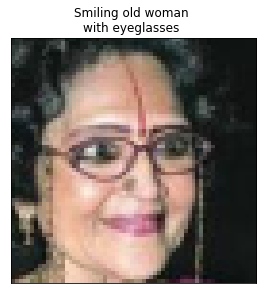

In [4]:
cd = ConditionDescriptor(y_sampler.conditions)
y = cd.create_y(Male=False, Smiling=True, Young=False, Eyeglasses=True)
#y = np.array([0, 1, 0, 0, 0])*2 - 1
idx = data.find_image(y)
img, z, y_new = data[idx]
print(y_new)
plot_batch([img], normalize=True, limit=1, descriptions=[cd.describe(y)])

In [5]:
generator = CGenerator5Net(Z_SIZE, Y_SIZE).cuda()
discriminator = CDiscriminator5(Y_SIZE).cuda()

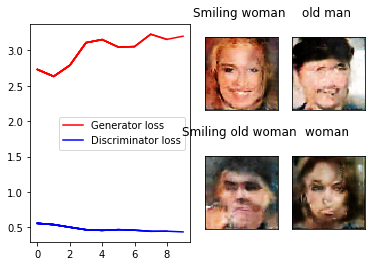

In [20]:
callback = cGanPlotLossCallback(generator, discriminator, y_sampler)
train(generator, discriminator, data_loader, y_sampler=y_sampler,
      n_epochs=279, k=1, callback_func=callback, model_path=MODEL_PATH, 
      continue_training=CONTINUE_TRAINING)


In [6]:
if LOAD_MODEL:
    generator.load_state_dict(torch.load(MODEL_PATH + 'generator_%d.pth' % (LOAD_EPOCH_N,)))
    discriminator.load_state_dict(torch.load(MODEL_PATH + 'discriminator_%d.pth' % (LOAD_EPOCH_N,)))

<class 'numpy.dtype'>
D_real:  3.7076492276355566e-07 D_fake:  2.1205230495979777e-06
D_logit_real:  -14.807697296142578 D_logit_fake:  -13.06384563446045
loss_on_real: tensor(12.9567, device='cuda:1')
loss_on_fake: tensor(1.00000e-06 *
       2.1458, device='cuda:1')
Discriminator loss:  6.478368759155273
loss_on_real: tensor(1.2500, device='cuda:1')
loss_on_fake: tensor(1.00000e-06 *
       2.1458, device='cuda:1')
0.6250237822532654


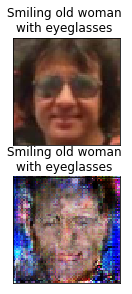

In [19]:
scalar = lambda v: np.asscalar(v.data.cpu().numpy())

Z = torch.normal(mean=torch.zeros(1, generator.z_size)).cuda()
        # 'Male', 'Smiling', 'Young', 'Eyeglasses', 'Wearing_Hat'
y = cd.create_y(Male=False, Smiling=True, Young=False, Eyeglasses=True)
print(dtype)
idx = data.find_image(y)
img, z, y_new = data[idx]
X = torch.tensor([img]).cuda()
y = y.astype(np.float32)
Y = torch.tensor([
                  y]).cuda()

G_sample = generator(Z, Y)
D_real, D_logit_real = discriminator(X, Y)
D_fake, D_logit_fake = discriminator(G_sample, Y)

generator_loss = GeneratorLoss()
discriminator_loss = DiscriminatorLoss(label_smoothing=0.25)

print("D_real: ", scalar(D_real), "D_fake: ", scalar(D_fake))
print("D_logit_real: ", scalar(D_logit_real), "D_logit_fake: ", scalar(D_logit_fake))

d_loss = discriminator_loss(D_logit_real, D_logit_fake)

print("Discriminator loss: ", scalar(d_loss))
print(scalar(discriminator_loss(torch.tensor([10.0]).cuda(), D_logit_fake)))
sample = np.concatenate((img[None, :, :, :], G_sample.data.cpu().numpy()))
plot_batch(sample, normalize=True, descriptions=[cd.describe(y)]*2)